# Probabilidad de Adición

(Escribir conexto****)

#### Librerias y conexión

Librerias

In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib

sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)

from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Transformación de las Variables y Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

Consulta SQL.

In [2]:
query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''

In [3]:
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset es de: {secop_I.shape[0]}\nEl número de columnas del dataset es de: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset es de: 26553
El número de columnas del dataset es de: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,...,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,...,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,...,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,...,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,...,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,...,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


#### Eliminación de columnas irrelevantes

In [4]:
# eliminación de variables con información poco relevante
secop_I_filter = secop_I.filter(items=['con_adicion_pptal', 'modalidad_de_contratacion', 'id_objeto_a_contratar', 
                                        'tipo_de_contrato', 'departamento_ejecucion', 'id_grupo',  
                                        'plazo_de_ejec_del_contrato_', 'tiempo_adiciones_en_dias', 
                                        'prorrogado', 'valor_contrato_con_adiciones'])
secop_I_filter.head(5)

,con_adicion_pptal,modalidad_de_contratacion,id_objeto_a_contratar,tipo_de_contrato,departamento_ejecucion,id_grupo,plazo_de_ejec_del_contrato_,tiempo_adiciones_en_dias,prorrogado,valor_contrato_con_adiciones
0,0,contratacion minima cuantia,50000000,suministro,cundinamarca,E,330,0,0,50000000
1,0,contratacion directa ley de,53000000,prestacion de servicios,bogota,E,660,30,1,22980096902
2,0,contratacion directa ley de,55000000,prestacion de servicios,bogota,E,31,40,1,35998452
3,0,contratacion directa ley de,72000000,prestacion de servicios,bogota,F,170,0,0,16767536
4,0,asociacion publico privada,73000000,no encontrado en hoja proceso,bogota,F,360,0,0,0


In [5]:
#---------- Grupo ----------
print(secop_I.groupby(['id_grupo', 'nombre_grupo'])['uid'].count().sort_values(ascending=False))

id_grupo  nombre_grupo                                       
E         productos de uso final                                 15875
F         servicios                                               4729
B         materias primas                                         2214
A         material vivo animal vegetal                            1518
D         componentes suministros                                 1241
C         maquinaria herramientas equipo industrial vehiculos      943
G         terrenos edificios estructuras vias                       33
Name: uid, dtype: int64


#### Casteo de las variables

In [6]:
# casteo de las variables
secop_I_filter['modalidad_de_contratacion'] = secop_I_filter['modalidad_de_contratacion'].astype('category')
secop_I_filter['id_objeto_a_contratar'] = secop_I_filter['id_objeto_a_contratar'].astype('category')
secop_I_filter['tipo_de_contrato'] = secop_I_filter['tipo_de_contrato'].astype('category')
secop_I_filter['departamento_ejecucion'] = secop_I_filter['departamento_ejecucion'].astype('category')
secop_I_filter['id_grupo'] = secop_I_filter['id_grupo'].astype('category')
secop_I_filter['plazo_de_ejec_del_contrato_'] = secop_I_filter['plazo_de_ejec_del_contrato_'].astype('category')
secop_I_filter['tiempo_adiciones_en_dias'] = secop_I_filter['tiempo_adiciones_en_dias'].astype('category')

In [7]:
secop_I_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   con_adicion_pptal             26553 non-null  Int64   
 1   modalidad_de_contratacion     26553 non-null  category
 2   id_objeto_a_contratar         26553 non-null  category
 3   tipo_de_contrato              26553 non-null  category
 4   departamento_ejecucion        26553 non-null  category
 5   id_grupo                      26553 non-null  category
 6   plazo_de_ejec_del_contrato_   26553 non-null  category
 7   tiempo_adiciones_en_dias      26553 non-null  category
 8   prorrogado                    26553 non-null  Int64   
 9   valor_contrato_con_adiciones  26553 non-null  Int64   
dtypes: Int64(3), category(7)
memory usage: 926.9 KB


#### Split de la variable dependiente de las varibales independientes

In [8]:
# conjunto de datos train
x_train = secop_I_filter.drop('con_adicion_pptal', axis=1)
y_adicion = secop_I_filter['con_adicion_pptal']

#### Preprocesamiento

In [9]:
num_col = x_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_col = x_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
num_trans = Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='median')), 
                             ('scaler', StandardScaler())])

# Transformaciones para las variables categóricas
cat_trans = Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='most_frequent')), 
                             ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', num_trans, num_col),
                        ('cat', cat_trans, cat_col)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out=False
               ).set_output(transform="pandas")

secop_I_filter_prep = preprocessor.fit_transform(x_train)

In [10]:
# conteo categorico
secop_I_filter_prep = pd.concat([secop_I_filter_prep, y_adicion], axis=1)
secop_I_filter_prep['con_adicion_pptal'].value_counts()

0    23756
1     2797
Name: con_adicion_pptal, dtype: Int64

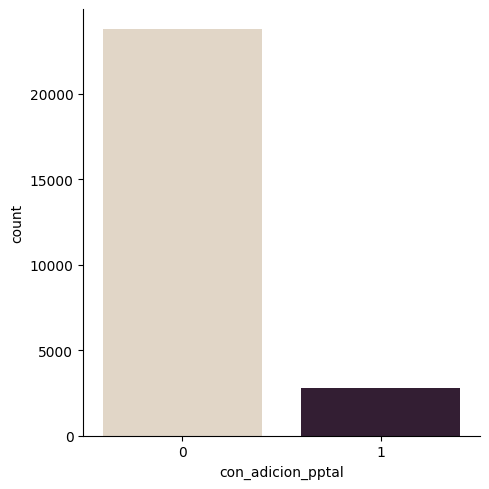

In [11]:
sns.catplot(data=secop_I_filter_prep, x="con_adicion_pptal", kind="count", palette="ch:.25")

Del análisis exploratorio se evidencio que las clases de la variable *con_adicion_pptal* se ecuentran significativamente desbalanceadas, por lo que cualquier análisis en conjunto, es decir, para identificar posibles relaciones con la variable de interés con las otras estará sesgada por dicho desbalanceo.

In [12]:
secop_I_filter_prep.head(5)

,prorrogado,valor_contrato_con_adiciones,modalidad_de_contratacion_asociacion publico privada,modalidad_de_contratacion_contratacion directa ley de,modalidad_de_contratacion_contratacion minima cuantia,modalidad_de_contratacion_licitacion publica,modalidad_de_contratacion_seleccion abreviada de menor cuantia ley de,modalidad_de_contratacion_seleccion abreviada del literal del numeral del articulo de la ley de,modalidad_de_contratacion_subasta,id_objeto_a_contratar_10000000,...,tiempo_adiciones_en_dias_150,tiempo_adiciones_en_dias_160,tiempo_adiciones_en_dias_177,tiempo_adiciones_en_dias_190,tiempo_adiciones_en_dias_200,tiempo_adiciones_en_dias_210,tiempo_adiciones_en_dias_229,tiempo_adiciones_en_dias_230,tiempo_adiciones_en_dias_240,con_adicion_pptal
0,-0.168135,0.196970,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,5.947602,130.946647,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5.947602,0.117132,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.168135,0.007475,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.168135,-0.088135,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Conjunto de datos en *train* y *test*

Se particiona el conjunto de datos dos subconjuntos de datos, train que es el conjunto de datos utilizados para entrenar los modelos el cual representa el 80% de los datos totales y test para comprobar el rendimiento de los modelos que representa el 20% restante.

In [13]:
# conjunto de datos train
train_datos = secop_I_filter_prep.sample(frac=0.9, random_state=0)

# conjunto de datos test
test_datos = secop_I_filter_prep.drop(train_datos.index)

In [14]:
train_datos

,prorrogado,valor_contrato_con_adiciones,modalidad_de_contratacion_asociacion publico privada,modalidad_de_contratacion_contratacion directa ley de,modalidad_de_contratacion_contratacion minima cuantia,modalidad_de_contratacion_licitacion publica,modalidad_de_contratacion_seleccion abreviada de menor cuantia ley de,modalidad_de_contratacion_seleccion abreviada del literal del numeral del articulo de la ley de,modalidad_de_contratacion_subasta,id_objeto_a_contratar_10000000,...,tiempo_adiciones_en_dias_150,tiempo_adiciones_en_dias_160,tiempo_adiciones_en_dias_177,tiempo_adiciones_en_dias_190,tiempo_adiciones_en_dias_200,tiempo_adiciones_en_dias_210,tiempo_adiciones_en_dias_229,tiempo_adiciones_en_dias_230,tiempo_adiciones_en_dias_240,con_adicion_pptal
23698,-0.168135,-0.088135,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
19086,-0.168135,-0.082432,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
20272,-0.168135,-0.055399,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
992,-0.168135,-0.077662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3302,-0.168135,-0.086425,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,-0.168135,-0.079354,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13737,-0.168135,-0.072768,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5958,-0.168135,-0.048221,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
997,-0.168135,-0.081909,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [15]:
train_datos.reset_index(inplace=True, drop=True)
test_datos.reset_index(inplace=True, drop=True)
print('Datos para el modelo: ' + str(train_datos.shape))
print('Datos para las predicciones: ' + str(test_datos.shape))

Datos para el modelo: (23898, 582)
Datos para las predicciones: (2655, 582)


#### Implementacion de los modelos
*(Tomado de la documentacion de PyCaret)*

Paso seguido se define el entorno de PyCaret con los datos de entrenamiento, esto hará que cada vez que se llame a un modelo a entrenar se escojan dichos datos para entrenar. Además este proceso también preprocesa los datos automáticamente de manera que sea más fácil aplicar los modelos estadísticos. Asimismo, se valida que tipo de modelos ofrece la libreria PyCaret.

##### Modelos de Clasificación

In [16]:
# definicion del modelo
from pycaret.classification import *
s = setup(train_datos,
            target='con_adicion_pptal',
            use_gpu=True,
            train_size=0.8,
            pca=True,
            session_id=123)
models()

,Description,Value
0,Session id,123
1,Target,con_adicion_pptal
2,Target type,Binary
3,Original data shape,"(23898, 582)"
4,Transformed data shape,"(23898, 582)"
5,Transformed train set shape,"(19118, 582)"
6,Transformed test set shape,"(4780, 582)"
7,Numeric features,581
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [17]:
# compare models
best = compare_models(probability_threshold=0.25)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9137,0.0000,0.2293,0.8411,0.3592,0.3289,0.4109,1.2020
ridge,Ridge Classifier,0.9135,0.0000,0.2308,0.8325,0.3604,0.3297,0.4098,0.9730
gbc,Gradient Boosting Classifier,0.9068,0.8437,0.4012,0.5900,0.4770,0.4279,0.4378,283.8440
lda,Linear Discriminant Analysis,0.9045,0.7911,0.2955,0.6038,0.3957,0.3505,0.3775,2.8190
lr,Logistic Regression,0.8988,0.8081,0.3488,0.5361,0.4220,0.3693,0.3799,3.8310
dummy,Dummy Classifier,0.8941,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8290
lightgbm,Light Gradient Boosting Machine,0.8917,0.8570,0.4852,0.4893,0.4869,0.4264,0.4266,4.2390
knn,K Neighbors Classifier,0.8818,0.7731,0.4743,0.4460,0.4594,0.3931,0.3936,1.3140
et,Extra Trees Classifier,0.8792,0.7641,0.4590,0.4334,0.4455,0.3778,0.3782,3.6560
nb,Naive Bayes,0.8760,0.7040,0.2851,0.3858,0.3270,0.2606,0.2646,0.9580


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [18]:
# mejor modelo
print(best)

CustomProbabilityThresholdClassifier(alpha=0.0001, average=False,
                                     class_weight=None,
                                     classifier=SGDClassifier(alpha=0.0001,
                                                              average=False,
                                                              class_weight=None,
                                                              early_stopping=False,
                                                              epsilon=0.1,
                                                              eta0=0.001,
                                                              fit_intercept=True,
                                                              l1_ratio=0.15,
                                                              learning_rate='optimal',
                                                              loss='hinge',
                                                              max_iter=1000,
            

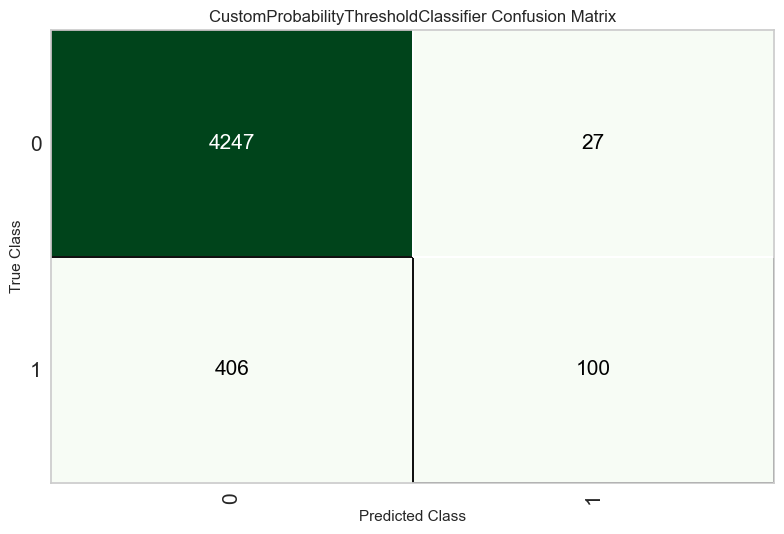

In [19]:
# plot confusion matrix
plot_model(best, plot='confusion_matrix')

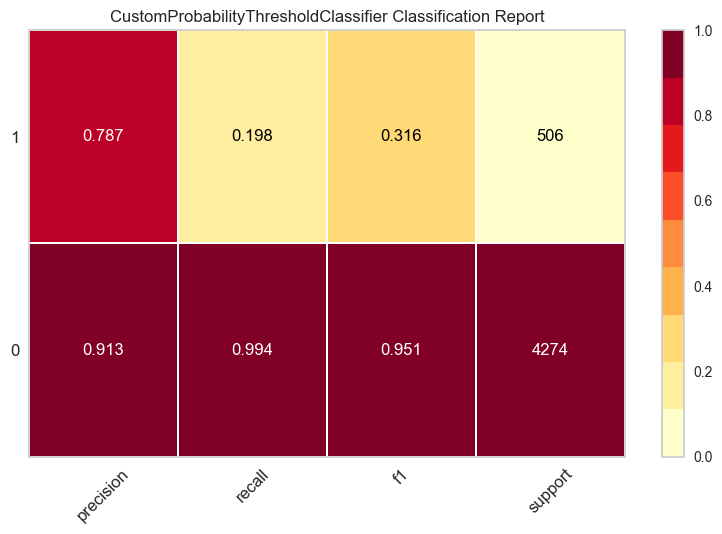

In [20]:
# plot confusion matrix
plot_model(best, plot='class_report')

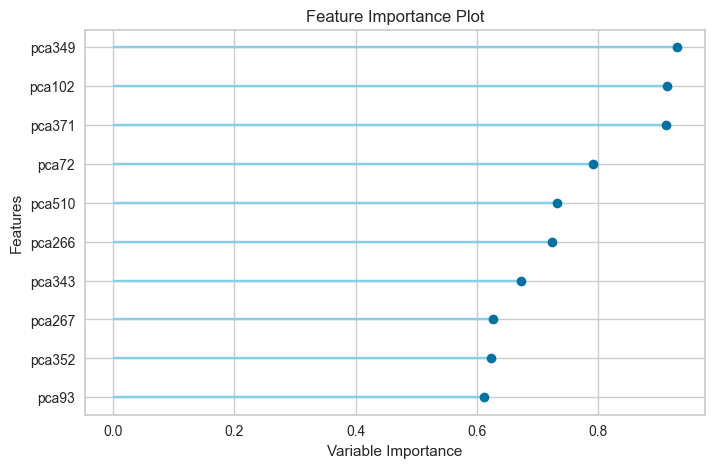

In [21]:
# plot feature importance
plot_model(best, plot='feature')